In [1]:
# prepare packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# get data sets
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../Data_sets/MNIST_data', one_hot=True)

Extracting ../Data_sets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
# our place holders
def model_inputs(image_width, image_height, image_channels, y_dim, z_dim):
    '''
    :param image_width: input image width. For MNIST 28
    :param image_height: input image height. For MNIST 28
    :param image_channel: input image channel. For MNIST 1
    :param y_dim: label input size to discriminator & generator. For MNIST 10
    :param z_dim: latent vector input size to generator. ex) 100
    '''
    inputs_x = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_x')
    inputs_y = tf.placeholder(tf.float32, [None, y_dim], name='inputs_y')
    inputs_y_reshaped = tf.placeholder(tf.float32, [None, image_width, image_height, y_dim], name='inputs_y_reshaped')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    
    return inputs_x, inputs_y, inputs_y_reshaped, inputs_z

In [4]:
# generator network structure
def generator(z, y, out_dim, reuse=False, initial_feature_size=512, alpha=0.2, is_training=True):
    '''
    :param z: placeholder of latent vector
    :param y: placeholder of labels: For MNIST shape=[batch_size, 10]
    '''
    with tf.variable_scope('generator', reuse=reuse):
        # weight initializer
        w_init = tf.contrib.layers.xavier_initializer()
        
        # concatenate inputs
        concatenated_inputs = tf.concat(values=[z, y], axis=1)
        
        # 1. Fully connected layer (make 3x3x512)
        feature_map_size = initial_feature_size
        first_layer_units = 3 * 3 * feature_map_size
        x1 = tf.layers.dense(inputs=concatenated_inputs, units=first_layer_units, activation=None, use_bias=True, kernel_initializer=w_init)
        x1 = tf.reshape(tensor=x1, shape=[-1, 3, 3, feature_map_size])
        x1 = tf.layers.batch_normalization(inputs=x1, training=is_training)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 2. convolutional layer (make 7x7x256)
        feature_map_size = feature_map_size // 2
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=feature_map_size, kernel_size=3, strides=2, padding='valid', kernel_initializer=w_init)
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 3. convolutional layer (make 14x14x128)
        feature_map_size = feature_map_size // 2
        x3 = tf.layers.conv2d_transpose(inputs=x2, filters=feature_map_size, kernel_size=5, strides=2, padding='same', kernel_initializer=w_init)
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer, 28 x 28 x out_dim
        logits = tf.layers.conv2d_transpose(inputs=x3, filters=out_dim, kernel_size=5, strides=2, padding='same', kernel_initializer=w_init)
        out = tf.tanh(logits)
        
        return out

In [5]:
# discriminator network structure
def discriminator(x, y_reshaped, reuse=False, initial_filter_size=64, alpha=0.2, is_training=True):
    '''
    :param x: placeholder of real or fake inputs. For MNIST shape=[batch_size, 28, 28, 1]
    :param y_reshaped: placeholder of labels. For MNIST shape=[batch_size, 28, 28, 10]
    '''
    with tf.variable_scope('discriminator', reuse=reuse):
        # weight initializer
        w_init = tf.contrib.layers.xavier_initializer()
        
        # x shape: 28x28x1
        # y_reshaped shape: 28x28x10
        # concatenate inputs (makes 28x28x11)
        concatenated_inputs = tf.concat(axis=3, values=[x, y_reshaped])
        
        # make 14x14x64
        filter_size = initial_filter_size
        x1 = tf.layers.conv2d(inputs=concatenated_inputs, filters=filter_size, kernel_size=5, strides=2, padding='same', kernel_initializer=w_init)
        x1 = tf.maximum(alpha * x1, x1)

        # make 7x7x128
        filter_size = filter_size * 2
        x2 = tf.layers.conv2d(inputs=x1, filters=filter_size, kernel_size=5, strides=2, padding='same', kernel_initializer=w_init)
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training)
        x2 = tf.maximum(alpha * x2, x2)
        
        # make 4x4x256
        filter_size = filter_size * 2
        x3 = tf.layers.conv2d(inputs=x2, filters=filter_size, kernel_size=5, strides=2, padding='same', kernel_initializer=w_init)
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # flatten the layer
        flattened_layer = tf.reshape(tensor=x3, shape=[-1, 4*4*filter_size])
        logits = tf.layers.dense(inputs=flattened_layer, units=1, activation=None, use_bias=True, kernel_initializer=w_init)
        out = tf.sigmoid(logits)
        
        return out, logits

In [6]:
def model_loss(inputs_x, inputs_y, inputs_y_reshaped, inputs_z, output_dim, alpha=0.2, smooth=0.0):
    # Generator network here (g_model is the generator output)
    g_model = generator(z=inputs_z, y=inputs_y, out_dim=output_dim, reuse=False, alpha=alpha, is_training=True)
    
    # Disriminator network here
    d_model_real, d_logits_real = discriminator(x=inputs_x, y_reshaped=inputs_y_reshaped, reuse=False, alpha=alpha, is_training=True)
    d_model_fake, d_logits_fake = discriminator(x=g_model, y_reshaped=inputs_y_reshaped, reuse=True, alpha=alpha, is_training=True)
    
    # Calculate losses
    real_labels = tf.ones_like(d_logits_real) * (1 - smooth) # label smoothing
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels) )
    
    fake_labels = tf.zeros_like(d_logits_real)
    d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=fake_labels) )
    
    d_loss = d_loss_real + d_loss_fake
    
    gen_labels = tf.ones_like(d_logits_fake)
    g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=gen_labels) )
    
    return d_loss, g_loss

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

In [8]:
# Size of input image to discriminator
image_width = 28
image_height = 28
image_channels = 1
# Size of labels (classes)
y_size = 10
# Size of latent vector to generator
z_size = 100
# Sizes of filter size in generator and discriminator
g_start_filter_size = 512
d_start_filter_size = 64
# learning rate
learning_rate = 0.001
# for leaky ReLU
alpha = 0.2
# adam optimizer
beta1 = 0.5
# Label smoothing 
smooth = 0.0

In [9]:
# Build Network

# wipe out previous graphs and make us to start building new graph from here
tf.reset_default_graph()

# Create our input placeholders
input_x, input_y, input_y_reshaped, input_z = model_inputs(image_width=image_width, 
                                                           image_height=image_height, 
                                                           image_channels=image_channels, 
                                                           y_dim=y_size, 
                                                           z_dim=z_size)

# build loss functions
d_loss, g_loss = model_loss(inputs_x=input_x, 
                            inputs_y=input_y, 
                            inputs_y_reshaped=input_y_reshaped,
                            inputs_z=input_z, 
                            output_dim=image_channels, 
                            alpha=alpha, 
                            smooth=smooth)

# Optimizers
d_opt, g_opt = model_opt(d_loss=d_loss, 
                         g_loss=g_loss, 
                         learning_rate=learning_rate, 
                         beta1=beta1)

In [10]:
def y_reshaper(y, width, height):
    '''
    :param y: label values (2d matrix)
    :param width: 
    :param height: 
    '''    
    y_shape = y.shape
    new_y = np.zeros((y_shape[0], width, height, y_shape[1]))
    
    for i in range(y_shape[0]):
        new_y[i, :, :, :] = y[i,:] * np.ones((width, height, y_shape[1]))
    return new_y

In [11]:
def generate_with_consistent_style(sess, input_z, input_y, n_style=10):
    latent_z = np.random.uniform(-1, 1, size=(n_style, z_size))
    
    generated_samples = []
    for s, sample_z in enumerate(latent_z):
        sample_z = np.reshape(sample_z, [1, z_size])
        
        each_class_samples = []
        for c in range(y_size):
            sample_y = np.zeros(shape=[1, y_size])
            sample_y[:, c] = 1
            
            gen_samples = sess.run( 
                generator(z=input_z, y=input_y, out_dim=image_channels, reuse=True, alpha=alpha, is_training=False),
                feed_dict={input_z: sample_z, input_y: sample_y})
            
            each_class_samples.append(gen_samples)
        generated_samples.append(each_class_samples)
    
    return generated_samples

In [12]:
y_temp = np.array([ [0, 0, 0, 1, 0], [1, 0, 0, 0, 0] ])
y_reshaped = y_reshaper(y_temp, 3, 3)
print(y_reshaped[0,:,:,0])
print(y_reshaped[0,:,:,1])
print(y_reshaped[0,:,:,2])
print(y_reshaped[0,:,:,3])
print(y_reshaped[0,:,:,4])

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


In [13]:
# Training session
batch_size = 64
epochs = 10
samples = []
losses = []
save_sample_every = epochs // 10
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            x_, y_ = mnist.train.next_batch(batch_size)
            
            # Get images, reshape (-1, 28, 28, 1) and rescale to pass to D
            x_ = x_.reshape(-1, image_width, image_height, image_channels)
            x_ = x_*2 - 1
            
            # also reshape y for ne reshaped placeholder
            y_reshaped_ = y_reshaper(y_, image_width, image_height)

            # Sample random noise for G
            z_ = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_opt, feed_dict={input_x: x_, input_y: y_, input_y_reshaped: y_reshaped_, input_z: z_})
            _ = sess.run(g_opt, feed_dict={input_z: z_, input_y: y_, input_y_reshaped: y_reshaped_, input_x: x_})
            
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_x: x_, input_y: y_, input_y_reshaped: y_reshaped_, input_z: z_})
        train_loss_g = g_loss.eval({input_z: z_, input_y: y_, input_y_reshaped: y_reshaped_, input_x: x_})
        
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        if e % save_sample_every == 0:
            # Sample from generator as we're training for viewing afterwards
            # sample each classes with same style
            samples_current_epoch = []
            for c in range(y_size):
                sample_z = np.random.uniform(-1, 1, size=(1, z_size))
                sample_y = np.zeros(shape=[1, y_size])
                sample_y[:, c] = 1
                gen_samples = sess.run( 
                    generator(z=input_z, y=input_y, out_dim=image_channels, reuse=True, alpha=alpha, is_training=False),
                    feed_dict={input_z: sample_z, input_y: sample_y})
                
                samples_current_epoch.append(gen_samples)
            samples.append(samples_current_epoch)
    
    final_samples = generate_with_consistent_style(sess, input_z, input_y, n_style=10)

Epoch 1/10... Discriminator Loss: 1.3480... Generator Loss: 0.7450
Epoch 2/10... Discriminator Loss: 1.3404... Generator Loss: 0.7257
Epoch 3/10... Discriminator Loss: 1.3509... Generator Loss: 0.5815
Epoch 4/10... Discriminator Loss: 1.3976... Generator Loss: 0.6810
Epoch 5/10... Discriminator Loss: 1.4596... Generator Loss: 0.5603
Epoch 6/10... Discriminator Loss: 1.2373... Generator Loss: 0.6328
Epoch 7/10... Discriminator Loss: 1.2452... Generator Loss: 0.5376
Epoch 8/10... Discriminator Loss: 1.1881... Generator Loss: 0.7395
Epoch 9/10... Discriminator Loss: 1.1387... Generator Loss: 0.9742
Epoch 10/10... Discriminator Loss: 1.6719... Generator Loss: 0.2789


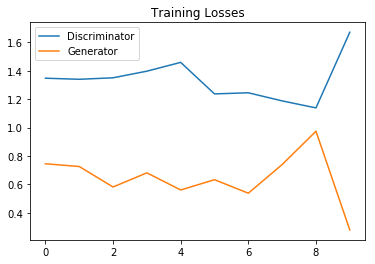

In [14]:
# display training loss
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [15]:
samples = np.array(samples)
final_samples = np.array(final_samples)
print('sample shape: ', samples.shape)
print('final_samples shape: ', final_samples.shape)

sample shape:  (10, 10, 1, 28, 28, 1)
final_samples shape:  (10, 10, 1, 28, 28, 1)


In [16]:
# generate generator samples
def view_samples(samples):
    n_epochs = samples.shape[0]
    n_classes = samples.shape[1]
    fig, axes = plt.subplots(figsize=(n_classes, n_epochs), nrows=n_epochs, ncols=n_classes, sharey=True, sharex=True)
    for samp, ax_row in zip(samples, axes):
        for single_class, ax in zip(samp, ax_row):
            ax.imshow(single_class.reshape((28,28)), cmap='Greys_r')
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
    return fig, axes

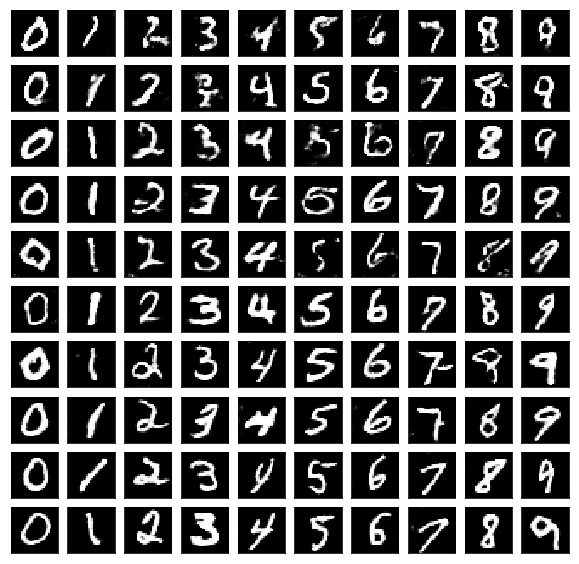

In [17]:
# view history of generated samples
_ = view_samples(samples)

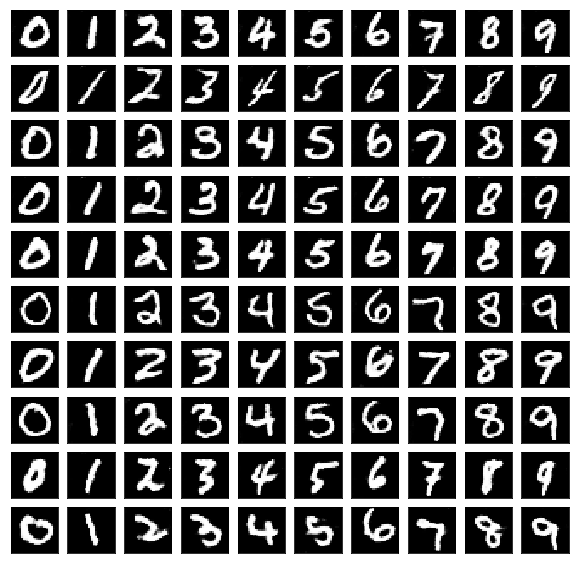

In [18]:
# view our generator results
_ = view_samples(final_samples)